In [ ]:
!pip install roboflow

In [1]:
from PIL import Image
import cv2
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


In [45]:
ssd_times = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/inference_times.csv')
yolo_times = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_inference_times.csv')
trad_times = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_inference_times.csv')

inf_times = pd.concat([ssd_times, yolo_times,trad_times], axis=1)

In [46]:
inf_times['SSD_Model'] = inf_times['SSD_Model'] * 1000
inf_times['Traditional_Model'] = inf_times['Traditional_Model'] * 1000
inf_times

,SSD_Model,YOLO_Model,Traditional_Model
0,137.867451,1410.129070,7.031202
1,14.368773,1084.629059,6.338596
2,19.081593,741.194963,14.252663
3,14.653444,539.505243,8.305550
4,14.485598,438.864946,12.207508
...,...,...,...
59,13.934851,237.333536,12.687922
60,16.359568,234.554529,5.809546
61,15.441179,249.424696,14.367342
62,14.496565,242.852449,8.043289


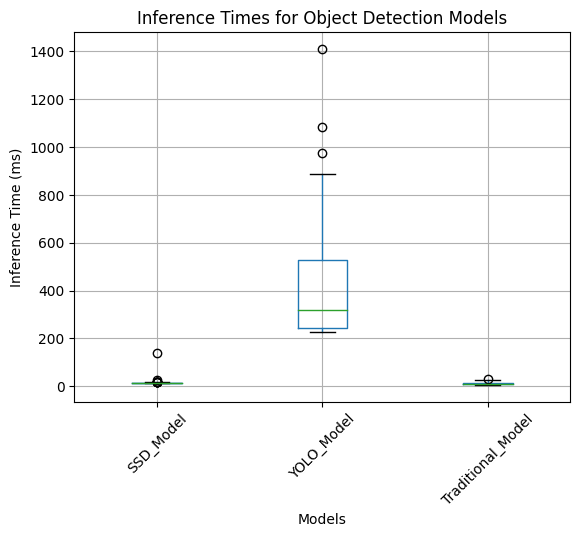

In [47]:
# Plot the boxplot without outliers
columns = ['SSD_Model', 'YOLO_Model', 'Traditional_Model']
inf_times.boxplot(column=columns)
plt.title('Inference Times for Object Detection Models')
plt.xlabel('Models')
plt.ylabel('Inference Time (ms)')
plt.xticks(rotation=45)
plt.show()

In [21]:
ssd_spread = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Data_Spread.csv')
yolo_spread = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Data_Spread.csv')
trad_spread = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_Model_Data_Spread.csv')

data_spread = pd.concat([ssd_spread, yolo_spread,trad_spread], axis=0)
data_spread['Models']= ['SSD', 'YOLO', 'Traditional']


In [26]:
ssd_curves_car = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Car_Class_APRF.csv')
ssd_curves_plate = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Plate_Class_APRF.csv')

yolo_curves_car = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Car_Class_APRF.csv')
yolo_curves_plate = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Plate_Class_APRF.csv')

trad_curves = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_Model_Plate_Class_APRF.csv')

In [29]:
trad_curves

,Image,TP,FP,FN,TP_acc,FP_acc,FN_acc,Precision,Recall,F1
0,Image 36,1,0,0,1,0,0,1.00,0.012821,0.000000
1,Image 5,1,0,0,2,0,0,1.00,0.025000,0.048780
2,Image 23,1,0,0,3,0,0,1.00,0.037037,0.071429
3,Image 23,1,0,0,4,0,0,1.00,0.048780,0.093023
4,Image 55,1,0,0,5,0,0,1.00,0.060241,0.113636
...,...,...,...,...,...,...,...,...,...,...
124,Image 25,0,0,1,24,72,29,0.25,0.235294,0.242424
125,Image 25,0,0,1,24,72,30,0.25,0.235294,0.242424
126,Image 25,0,0,1,24,72,31,0.25,0.235294,0.242424
127,Image 25,0,0,1,24,72,32,0.25,0.235294,0.242424


In [33]:
data = {
    'Predicted Cars': [ssd_curves_car.iloc[-1]['TP_acc'],yolo_curves_car.iloc[-1]['TP_acc'], float('nan')],
    'Actual Cars': data_spread['Actual Cars'],
    'Predicted Plates': [ssd_curves_plate.iloc[-1]['TP_acc'],yolo_curves_plate.iloc[-1]['TP_acc'], trad_curves.iloc[-1]['TP_acc']],
    'Actual Plates': data_spread['Actual Plates'],
    'Models':['SSD', 'YOLO', 'Traditional']
}

df = pd.DataFrame(data)
df


,Predicted Cars,Actual Cars,Predicted Plates,Actual Plates,Models
0,67.0,125.0,11,78,SSD
0,104.0,125.0,66,78,YOLO
0,NaN,NaN,24,78,Traditional


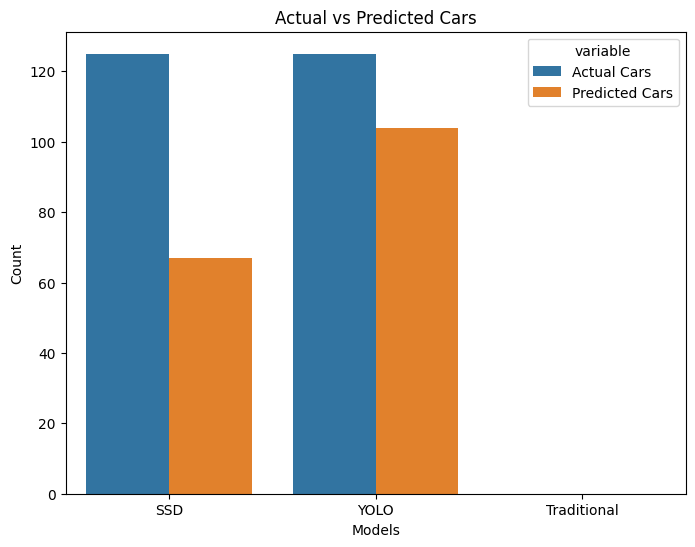

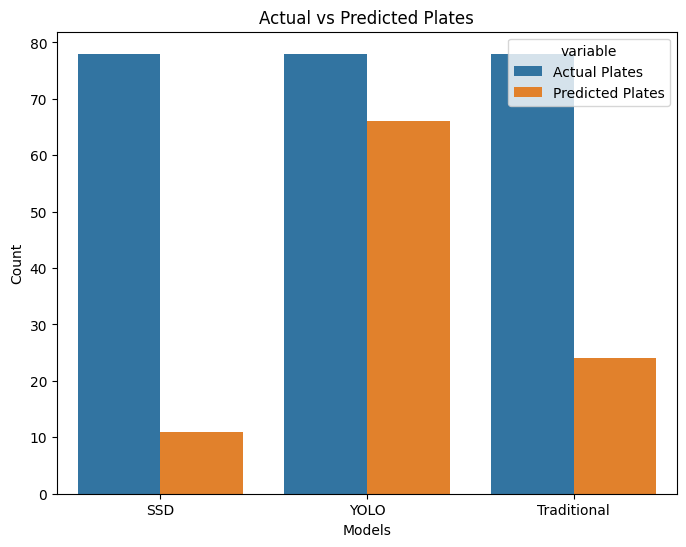

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better visibility
# Plot actual and predicted cars
plt.figure(figsize=(8, 6))
sns.barplot(x='Models', y='value', hue='variable', data=pd.melt(df, id_vars=['Models'], value_vars=['Actual Cars', 'Predicted Cars']))
plt.title('Actual vs Predicted Cars')
plt.ylabel('Count')
plt.xlabel('Models')
plt.show()

# Plot actual and predicted plates
plt.figure(figsize=(8, 6))
sns.barplot(x='Models', y='value', hue='variable', data=pd.melt(df, id_vars=['Models'], value_vars=['Actual Plates', 'Predicted Plates']))
plt.title('Actual vs Predicted Plates')
plt.ylabel('Count')
plt.xlabel('Models')
plt.show()

#PR Curves

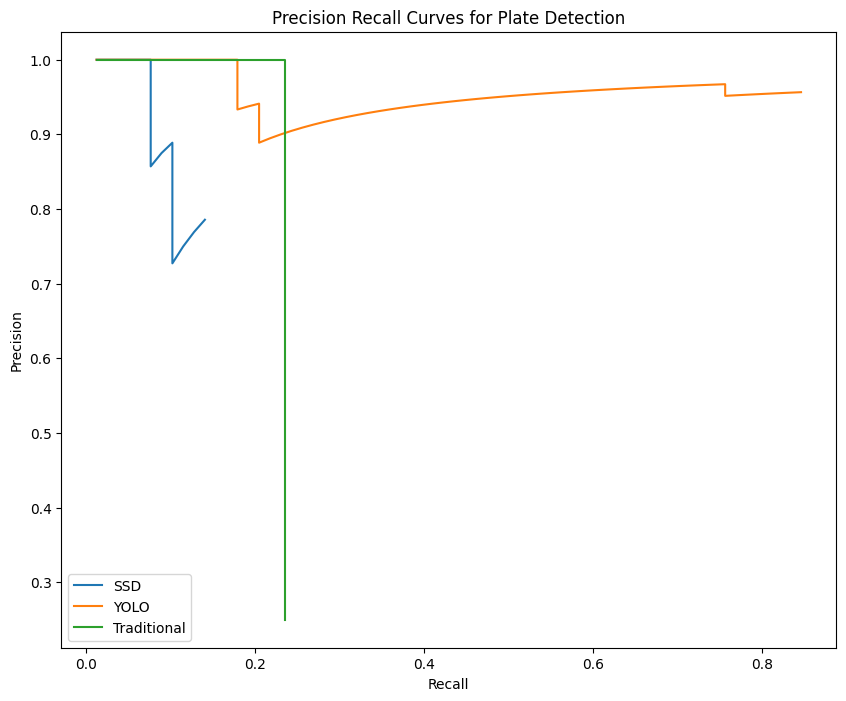

In [42]:
plt.figure(figsize=(10,8))
plt.plot(ssd_curves_plate['Recall'], ssd_curves_plate['Precision'])
plt.plot(yolo_curves_plate['Recall'], yolo_curves_plate['Precision'])
plt.plot(trad_curves['Recall'], trad_curves['Precision'])

plt.legend(['SSD', 'YOLO','Traditional'])
plt.title('Precision Recall Curves for Plate Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()

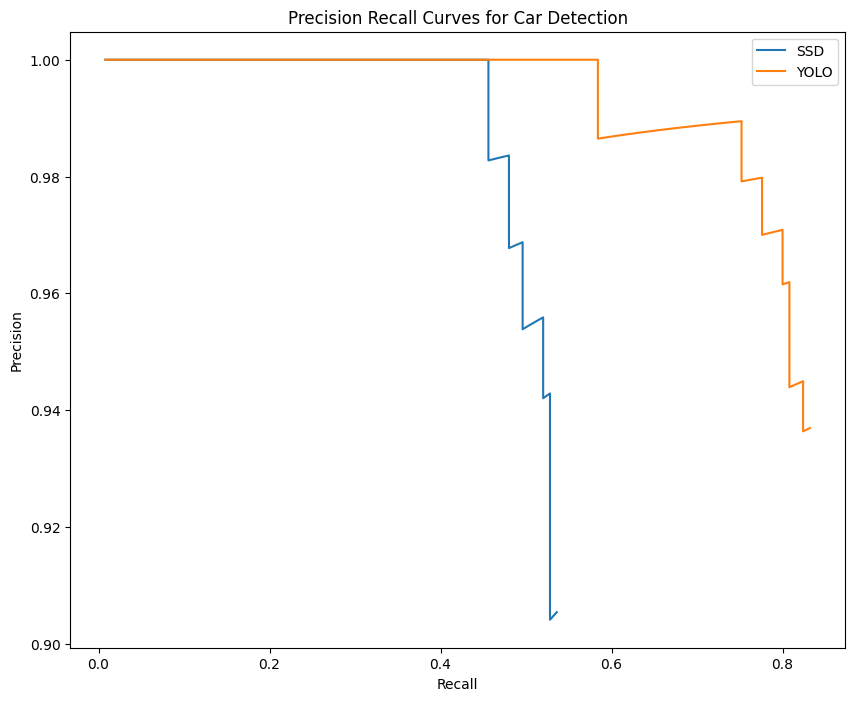

In [43]:
plt.figure(figsize=(10,8))
plt.plot(ssd_curves_car['Recall'], ssd_curves_car['Precision'])
plt.plot(yolo_curves_car['Recall'], yolo_curves_car['Precision'])
# plt.plot(trad_curves['Recall'], trad_curves['Precision'])

plt.legend(['SSD', 'YOLO'])
plt.title('Precision Recall Curves for Car Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()